# Intro

Streamlit app can be found here: https://andreas-fluckiger-mandatory-ind320.streamlit.app 

The Github repository can be found here: https://github.com/Fluckigerandreas/Mandatory_assignment_IND320.git

# Code

✅ Connected to MongoDB

✅ Downloaded ERA5 data for Bergen
                           temperature_2m  precipitation  wind_speed_10m  \
time                                                                       
2019-01-01 00:00:00+01:00           7.155            0.3       39.404789   
2019-01-01 01:00:00+01:00           7.055            0.4       43.919998   
2019-01-01 02:00:00+01:00           7.305            0.5       47.081612   
2019-01-01 03:00:00+01:00           7.455            0.7       50.432129   
2019-01-01 04:00:00+01:00           7.005            0.5       51.430885   

                           wind_gusts_10m  wind_direction_10m  
time                                                           
2019-01-01 00:00:00+01:00       87.120003          264.758270  
2019-01-01 01:00:00+01:00       95.039993          280.388794  
2019-01-01 02:00:00+01:00       85.320000          293.428711  
2019-01-01 03:00:00+01:00       91.799995          308.915314  
2019-01-01 04:00:00+01:00

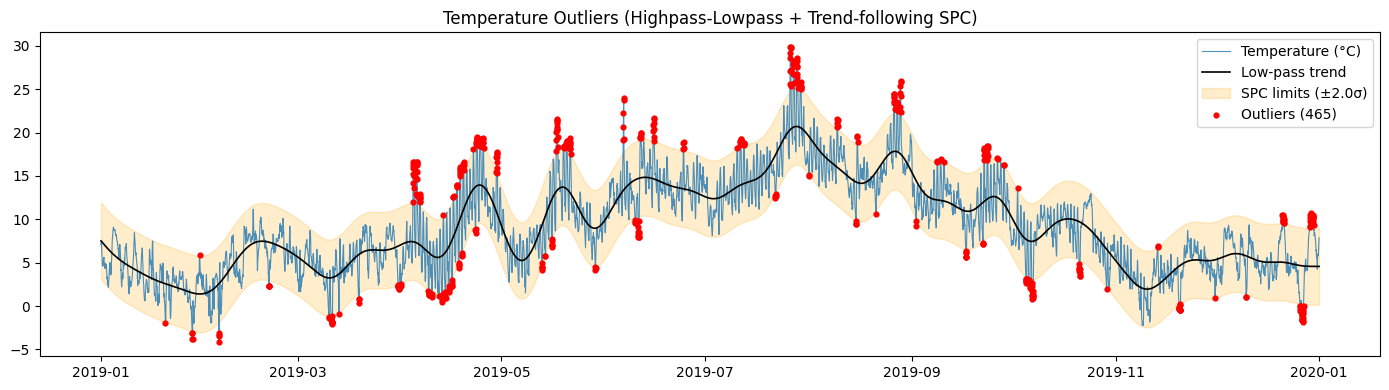

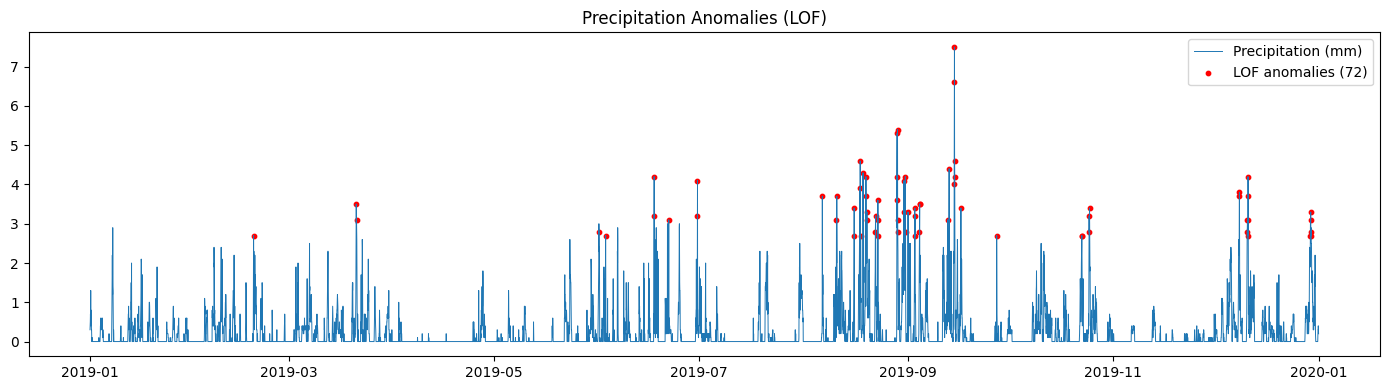

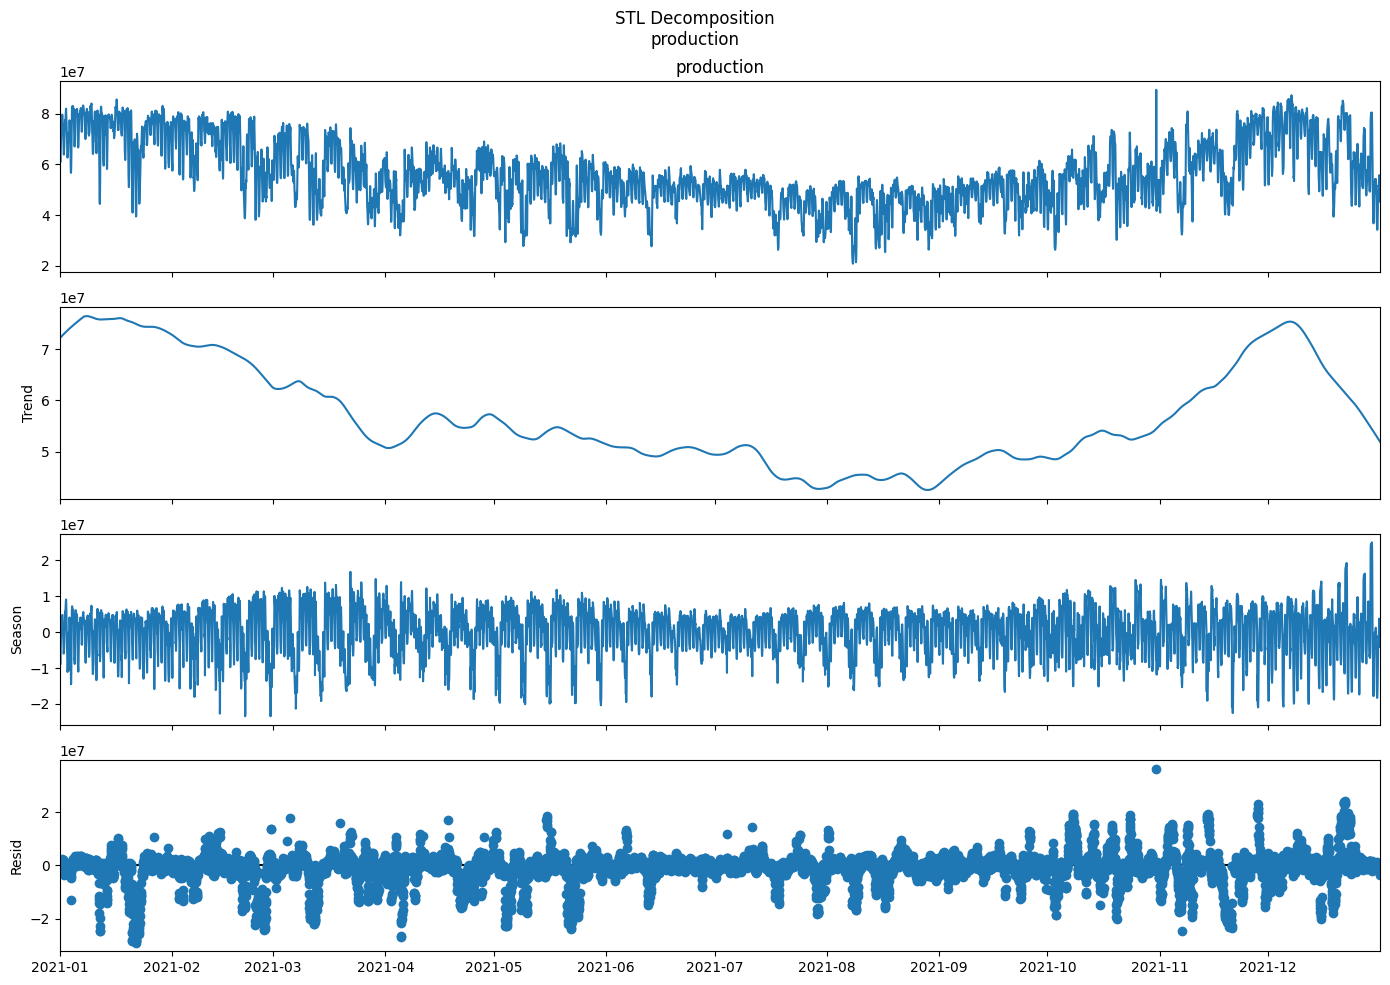

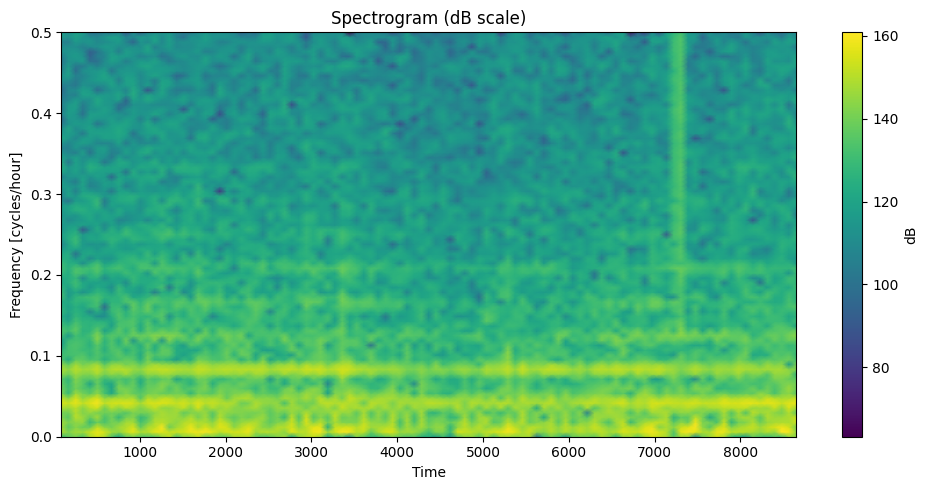

In [43]:
# ======================================================
#   IMPORTS
# ======================================================
import os
import sys
import requests_cache
import openmeteo_requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from retry_requests import retry
from scipy.fftpack import dct, idct
from sklearn.neighbors import LocalOutlierFactor
from statsmodels.tsa.seasonal import STL
from scipy import signal
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
import certifi
from scipy.signal import butter, filtfilt

from mysecrets import USERNAME, PASSWORD  # Secure credentials

# ======================================================
#   PRICE AREAS (CITIES)
# ======================================================
price_areas = [
    {"price_area": "NO1", "city": "Oslo", "latitude": 59.9139, "longitude": 10.7522},
    {"price_area": "NO2", "city": "Kristiansand", "latitude": 58.1467, "longitude": 7.9956},
    {"price_area": "NO3", "city": "Trondheim", "latitude": 63.4305, "longitude": 10.3951},
    {"price_area": "NO4", "city": "Tromsø", "latitude": 69.6492, "longitude": 18.9553},
    {"price_area": "NO5", "city": "Bergen", "latitude": 60.3913, "longitude": 5.3221},
]

cities_df = pd.DataFrame(price_areas)

# ======================================================
#   1) CONNECT TO MONGODB
# ======================================================
def connect_mongo():
    """Connect to MongoDB cluster using credentials."""
    ca = certifi.where()
    uri = (
        f"mongodb+srv://{USERNAME}:{PASSWORD}"
        "@cluster0.chffuae.mongodb.net/?retryWrites=true&w=majority&appName=Cluster0"
    )
    client = MongoClient(uri, server_api=ServerApi("1"), tls=True, tlsCAFile=ca)
    client.admin.command("ping")
    print("✅ Connected to MongoDB")
    return client


# ======================================================
#   2) DOWNLOAD ERA5 WEATHER DATA
# ======================================================
def download_era5_openmeteo(lat, lon, year, timezone="Europe/Oslo"):
    """Download ERA5 reanalysis hourly data from Open-Meteo."""
    cache_session = requests_cache.CachedSession(".cache", expire_after=-1)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": f"{year}-01-01",
        "end_date": f"{year}-12-31",
        "hourly": [
            "temperature_2m",
            "precipitation",
            "wind_speed_10m",
            "wind_gusts_10m",
            "wind_direction_10m",
        ],
        "models": "era5",
        "timezone": timezone,
    }

    response = openmeteo.weather_api(url, params=params)[0]
    hourly = response.Hourly()

    df = pd.DataFrame(
        {
            "time": pd.date_range(
                start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
                end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
                freq=pd.Timedelta(seconds=hourly.Interval()),
                inclusive="left",
            ),
            "temperature_2m": hourly.Variables(0).ValuesAsNumpy(),
            "precipitation": hourly.Variables(1).ValuesAsNumpy(),
            "wind_speed_10m": hourly.Variables(2).ValuesAsNumpy(),
            "wind_gusts_10m": hourly.Variables(3).ValuesAsNumpy(),
            "wind_direction_10m": hourly.Variables(4).ValuesAsNumpy(),
        }
    )
    df["time"] = df["time"].dt.tz_convert(timezone)
    df.set_index("time", inplace=True)
    return df

def detect_temperature_outliers_filter(df, temp_col="temperature_2m", cutoff_hours=400,
                                       sample_rate_hours=1, n_std=2.0):
    """
    Detect temperature outliers using a highpass-lowpass Butterworth filter + SPC
    with trend-following boundaries.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with datetime index and temperature column.
    temp_col : str
        Column name for temperature data.
    cutoff_hours : float
        Period defining low-frequency cutoff (in hours).
    sample_rate_hours : float
        Sampling interval of your data (1 = hourly data).
    n_std : float
        Number of standard deviations for SPC threshold.

    Returns
    -------
    outliers : pd.DataFrame
        DataFrame containing detected outliers.
    """
    s = df[temp_col].dropna().sort_index()
    x = s.values.astype(float)

    # --- Define cutoff frequency (normalized) ---
    nyquist = 0.5 / sample_rate_hours
    cutoff_freq = 1 / cutoff_hours  # convert period (hours) → frequency (1/hour)
    normal_cutoff = cutoff_freq / nyquist

    # --- Low-pass Butterworth filter to estimate the trend ---
    b, a = butter(N=4, Wn=normal_cutoff, btype="low", analog=False)
    trend = filtfilt(b, a, x)

    # --- High-pass (detrended) residuals ---
    residual = x - trend

    # --- Local SPC boundaries around the trend ---
    sigma_hat = 1.4826 * np.median(np.abs(residual - np.median(residual)))  # robust std estimate
    upper = trend + n_std * sigma_hat
    lower = trend - n_std * sigma_hat

    # --- Detect outliers ---
    mask = (x > upper) | (x < lower)
    outliers = pd.DataFrame({"temperature": x[mask]}, index=s.index[mask])

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(s.index, x, lw=0.8, label="Temperature (°C)", alpha=0.8)
    ax.plot(s.index, trend, color="black", lw=1.2, label="Low-pass trend")
    ax.fill_between(s.index, lower, upper, color="orange", alpha=0.2, label="SPC limits (±{:.1f}σ)".format(n_std))
    ax.scatter(outliers.index, outliers["temperature"], color="red", s=12, zorder=5, label=f"Outliers ({len(outliers)})")

    ax.set_title("Temperature Outliers (Highpass-Lowpass + Trend-following SPC)")
    ax.legend()
    plt.tight_layout()
    plt.show()

    return outliers




# ======================================================
#   4) PRECIPITATION ANOMALIES FUNCTION (LOF)
# ======================================================
def detect_precipitation_lof(df, precip_col="precipitation", proportion=0.01):
    """Detect precipitation anomalies using Local Outlier Factor (LOF)."""
    p = df[precip_col].fillna(0).sort_index()
    X = p.values.reshape(-1, 1)
    lof = LocalOutlierFactor(n_neighbors=min(len(p) - 1, 20), contamination=proportion)
    y_pred = lof.fit_predict(X)

    outliers = pd.DataFrame({"precipitation": p.values[y_pred == -1]}, index=p.index[y_pred == -1])

    # Plot
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(p.index, p.values, lw=0.7, label="Precipitation (mm)")
    ax.scatter(outliers.index, outliers["precipitation"], color="red", s=10, label=f"LOF anomalies ({len(outliers)})")
    ax.set_title("Precipitation Anomalies (LOF)")
    ax.legend()
    plt.tight_layout()
    plt.show()

    return outliers


# ======================================================
#   5) LOAD ELHUB PRODUCTION DATA
# ======================================================
def load_all_elhub_production(client, db_name="example", collection_name="data"):
    """Load all Elhub production data from MongoDB."""
    db = client[db_name]
    coll = db[collection_name]
    df = pd.DataFrame(list(coll.find()))

    if df.empty:
        raise ValueError(f"No documents found in {db_name}.{collection_name}")

    datetime_col = next((c for c in df.columns if "start" in c.lower()), None)
    quantity_col = next((c for c in df.columns if "quantity" in c.lower()), None)
    if not datetime_col or not quantity_col:
        raise ValueError("Missing datetime or quantity column")

    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df.set_index(datetime_col, inplace=True)
    df = df.groupby(df.index).agg({quantity_col: "sum"})
    df.rename(columns={quantity_col: "production"}, inplace=True)
    return df


# ======================================================
#   6) STL DECOMPOSITION (DST-SAFE)
# ======================================================
def stl_decompose_series(series, period=24*7, title="STL Decomposition"):
    """
    Perform STL decomposition on a time series with DST and irregular spacing handled.
    Converts to UTC, enforces regular hourly frequency, interpolates missing data.
    """
    series = series.sort_index()

    # --- Handle timezone & DST ---
    if series.index.tz is not None:
        series = series.tz_convert("UTC")
    else:
        series.index = series.index.tz_localize("UTC")

    # --- Regularize to hourly frequency ---
    series = series.asfreq("h")
    series = series.interpolate(method="time")

    # --- Run STL ---
    stl = STL(series, period=period, robust=True)
    result = stl.fit()

    # --- Plot ---
    fig = result.plot()
    fig.set_size_inches(14, 10) 
    fig.suptitle(f"{title}\n{series.name}", fontsize=12)
    plt.tight_layout()
    plt.show()

    return result


# ======================================================
#   7) SPECTROGRAM
# ======================================================
def plot_spectrogram(series, fs=1.0, nperseg=24 * 7, noverlap=None):
    """Plot the spectrogram of a time series."""
    s = series.dropna().astype(float)
    noverlap = noverlap or nperseg // 2
    f, t, Sxx = signal.spectrogram(s.values, fs=fs, window="hann", nperseg=nperseg, noverlap=noverlap)
    fig, ax = plt.subplots(figsize=(10, 5))
    pcm = ax.pcolormesh(t, f, 10 * np.log10(Sxx + 1e-12), shading="gouraud")
    ax.set_title("Spectrogram (dB scale)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Frequency [cycles/hour]")
    plt.colorbar(pcm, ax=ax, label="dB")
    plt.tight_layout()
    plt.show()
    return f, t, Sxx


# ======================================================
#   8) MAIN EXECUTION
# ======================================================
if __name__ == "__main__":
    client = connect_mongo()

    # --- Select city (Bergen here) ---
    city_name = "Bergen"
    city_info = cities_df.query("city == @city_name").iloc[0]

    # --- Download weather data ---
    weather_df = download_era5_openmeteo(city_info.latitude, city_info.longitude, 2019)
    print(f"\n✅ Downloaded ERA5 data for {city_name}")
    print(weather_df.head())

    # --- Load Elhub production data ---
    full_elhub_df = load_all_elhub_production(client)

    # --- Run analyses ---
    temp_outliers = detect_temperature_outliers_filter(weather_df)
    precip_outliers = detect_precipitation_lof(weather_df)
    stl_res = stl_decompose_series(full_elhub_df["production"])
    f, t, Sxx = plot_spectrogram(full_elhub_df["production"])


# Log

The third compulsory assignment focused on integrating live weather data from the Open-Meteo API into an interactive Streamlit application. Unlike previous assignments, which relied on local CSV files, all data in this project was retrieved dynamically from the API. This approach required careful management of requests and caching to ensure efficient performance and a smooth user experience.

A central aspect of the project was optimizing usability. All interactive controls—such as city selection, variable selection, and month range—were positioned directly on the main page rather than in a sidebar, creating a more intuitive interface. Streamlit’s caching functionality, provided by @st.cache_data, played a key role in minimizing redundant API calls and improving responsiveness when switching between cities or weather variables.

During development, it became evident that load times varied between cities due to geographic factors, including latitude and the internal processing of ERA5 reanalysis data. High-latitude locations, such as Tromsø, required slightly longer response times because the API performs additional interpolation for polar regions. Recognizing these differences underscored the importance of user feedback, interface responsiveness, and performance optimization.

For data visualization, Altair was chosen for its flexibility and support for interactive, multi-variable plots. Users can select a single weather variable or view all available variables simultaneously, and the month-range filter enables focused exploration of seasonal patterns. This level of interactivity provides deeper insights compared to static plots and aligns with the goal of building a modern, web-based visualization platform. Matplotlib was also employed for its simplicity and convenience when exporting visualizations to PDF, while Plotly was used in certain cases to provide enhanced interactive plots.

All API handling, variable selection, and plotting logic were implemented within a single Streamlit file, simplifying the overall structure and improving maintainability. Additionally, the city (price area) selection option was not linked from page 2 to the Extreme Event Analysis page, as relocating this functionality resulted in a more coherent and efficient user experience.

Finally, the anomaly detection algorithms were adapted slightly from the original notebook for the Streamlit application. While this produces slightly different plots, the core functionality and expected outcomes remain consistent. Higher outlier percentages still correspond to more detected anomalies.

# AI assistance 
Throughout the assignment, ChatGPT was used extensively for code guidance, debugging, and optimization suggestions. Key contributions included:

- Error troubleshooting: Identifying causes of module import errors and Streamlit deprecation warnings.
- Code refactoring: Combining CSV reading, API fetching, and plotting logic into a single, streamlined, and interactive file.
- UX improvements: Recommending appropriate caching strategies to enhance performance when fetching full-year hourly data.

While the AI occasionally required iterative prompting to refine solutions, it substantially accelerated development, reduced debugging time, and clarified technical design decisions. This allowed me to focus on creating a user-friendly, responsive, and fully interactive Streamlit application.